In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

def round1adjust(annot, linreg):
    #Set up empty dataframe
    index=['0']
    Out_Lin_reg = pd.DataFrame(index=index, columns=linreg.columns)
    Out_Lin_reg = Out_Lin_reg.fillna(0)
    Out_Lin_reg['PVAL']=0
    Test=[]        #Number of STRs tested for a gene
    Notest=[]      #Gene twith no tested genes
    for index, gene in annot.iterrows():
        geneid = gene['gene.id']
        start = gene['gene.start']
        stop = gene['gene.stop']
#        strs = linreg.loc[linreg['str.start'].isin(range(start,stop))]
        strs = linreg.loc[linreg['gene'].isin([geneid])]
        N = len(strs)
    #print (N,' ',gene['gene.id'], '\t', len(list(strs['p.wald'])),'\t', min(strs['p.wald']))
    
#identifying the STR test with smallest pvalue
        if N>0 :
            ind_low = strs.loc[strs['p.wald'].idxmin()]
            lowpval = strs.loc[[ind_low.name]]
            print (N,' ',gene['gene.id'], '\t', len(list(strs['p.wald'])),'\t', min(strs['p.wald']))
#adjusting by the number of tests
            Adj_pval = lowpval['p.wald']*N
            lowpval['PVAL'] = Adj_pval
            print (gene['gene.id'], '\t', lowpval['gene'],'\t',N)
    
#Append adjusted STR in the output for final FDR adjustment
            Out_Lin_reg.loc[len(Out_Lin_reg)] = lowpval.values.tolist()[0]
            Test.append(N)
    
        else:
            Notest.append(gene['gene.id']) 
            print(gene['gene.id'],'----------------------------------')
        
    Out_Lin_reg.drop('0')
    return(Out_Lin_reg, Notest, Test)

In [2]:
#open gene annotation
annot = pd.read_csv('~/projects/GTEX_eSTRs/data/Lin_Reg/Gene_Exp_Annotation.txt', sep=',')
#Looking at these columns gene.chr	gene.start	gene.stop	gene.id

#open Linear regression output
linreg = pd.read_csv('/storage/szfeupe/Runs/GTEx_estr/Analysis_by_Tissue/WholeBlood/Lin_Reg_Out', sep='\t')
#Looking at these columns gene	chrom	str.start	p.wald

#Set up the test set
chrom = ['chr'+str(i) for i in range(1,22)]
chrom.append('chrX') ; chrom.append('chrY')

'''
#Setting up
index=['0']
Adjusted_1 = pd.DataFrame(index=index, columns=linreg.columns)
Adjusted_1 = Adjusted_1.fillna(0)
Out_Lin_reg['PVAL']=0
#phase1 single out the STR with lowest pval and adjust by chromosome
for ch in chrom:
    annot = annot.loc[annot['gene.chr'].isin([ch])]
    linreg = linreg.loc[linreg['chrom'].isin([ch])]
    Adj_Lin_reg, gene_no_test, nbr_Test = round1adjust(annot, linreg)
    Adjusted_1.append(Adj_Lin_reg, ignore_index=True)
print('End')
Adjusted_1.to_csv('LinReg_adj1.tsv', sep='\t')
'''

annot = annot.loc[annot['gene.chr'].isin(['chr1'])]
linreg = linreg.loc[linreg['chrom'].isin(['chr1'])]
print (annot.shape)

(1998, 10)


In [3]:
index=['0']
Out_Lin_reg = pd.DataFrame(index=index, columns=linreg.columns)
Out_Lin_reg = Out_Lin_reg.fillna(0)
Out_Lin_reg['PVAL']=0
Test=[]        #Number of STRs tested for a gene
Notest=[]      #Gene twith no tested genes
genes=[]; strid=[]; pvalue=[]; Nbr_test=[]
#For each gene in the set, count the number N of tested STRs
for index, gene in annot.iterrows():
    geneid = gene['gene.id']
    start = gene['gene.start']
    stop = gene['gene.stop']
#    strs = linreg.loc[linreg['str.start'].isin(range(start,stop))]
    strs = linreg.loc[linreg['gene'].isin([geneid])]
    N = len(strs)
    #print (N,' ',gene['gene.id'], '\t', len(list(strs['p.wald'])),'\t', min(strs['p.wald']))
    
#identifying the STR test with smallest pvalue
    if N>0 :
        ind_low = strs.loc[strs['p.wald'].idxmin()]
        lowpval = strs.loc[[ind_low.name]]
        #print (strs['p.wald'], '\n\n', lowpval['p.wald'])
#        print (N,' ',gene['gene.id'], '\t', len(list(strs['p.wald'])),'\t', min(strs['p.wald']))
#adjusting by the number of tests
        Adj_pval = lowpval['p.wald']*N
        lowpval['PVAL'] = Adj_pval
#        print (gene['gene.id'], '\t', lowpval['gene'],'\t',N)
    
#Append adjusted STR in the output for final FDR adjustment
        Out_Lin_reg.loc[len(Out_Lin_reg)] = lowpval.values.tolist()[0]
        Test.append(N)
    
    else:
        Notest.append(gene['gene.id']) 
        #print(gene['gene.id'],'----------------------------------')

Out_Lin_reg = Out_Lin_reg.drop('0')
print(len(Notest), ' genes were not tested for eSTRs')
print(len(Test), ' genes were tested for eSTRs')

1530  genes were not tested for eSTRs
468  genes were tested for eSTRs


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


468
34


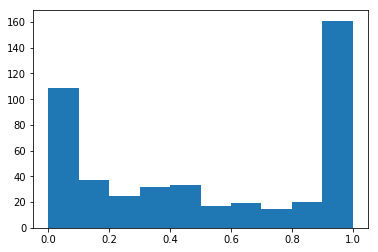

In [9]:
import subprocess
#SOmetime, the p-values multiplied by the number of STRs is >1 
Out_Lin_reg['PVAL'][Out_Lin_reg['PVAL']>1] = 1
PVAL=Out_Lin_reg['PVAL']
print(len(PVAL))
print(len(PVAL[PVAL<0.005]))
#Save the corrected to file calles pvalues.txt
PVAL.to_csv('pvalues.txt', sep='\n', index=False)
#Now, we use the QVALUE package to adjust the pvalues and obtain the qvalues
Tell = subprocess.call("./fdr-correct.r")
Qval=pd.read_csv('qvalues.txt', sep=' ')

Out_Lin_reg['pvalue1']=list(Qval['pvalue'])
Out_Lin_reg['#oftest']=Test
Out_Lin_reg['qvalue']=list(Qval['qvalue'])
Out_Lin_reg['significant']=list(Qval['significant'])

plt.hist(PVAL)
plt.show()
#Qval[Qval['significant']==1]

In [10]:
Out_Lin_reg.to_csv('fdr-p-qvalues.txt', sep='\t', index=False)
Out_Lin_reg

,Unnamed: 0,gene,chrom,str.id,str.start,n.miss,allele1.dummy,allele2.dummy,af.dummy,beta,beta.se,lambda.remel,p.wald,PVAL,pvalue1,#oftest,qvalue,significant
1,21,ENSG00000237683.5,chr1,STR_101673,101673,20,A,G,0,0.195525,0.089154,-1,3.021201e-02,1.000000e+00,1.000000e+00,50,0.852327,0
2,54,ENSG00000188976.6,chr1,STR_834405,834405,23,A,G,0,0.234674,0.089487,-1,9.881334e-03,4.248974e-01,4.248974e-01,43,0.770226,0
3,95,ENSG00000187961.9,chr1,STR_807303,807303,20,A,G,0,-0.206698,0.088946,-1,2.180135e-02,9.374581e-01,9.374581e-01,43,0.852327,0
4,138,ENSG00000187583.6,chr1,STR_807303,807303,20,A,G,0,-0.267615,0.087593,-1,2.767267e-03,1.189925e-01,1.189925e-01,43,0.407727,0
5,204,ENSG00000187642.5,chr1,STR_954850,954850,11,A,G,0,0.197893,0.085971,-1,2.293357e-02,9.173429e-01,9.173429e-01,40,0.852327,0
6,252,ENSG00000188290.6,chr1,STR_966146,966146,5,A,G,0,-0.202782,0.083968,-1,1.706412e-02,7.166931e-01,7.166931e-01,42,0.852327,0
7,297,ENSG00000187608.5,chr1,STR_1032965,1032965,40,A,G,0,0.168388,0.098083,-1,8.908270e-02,1.000000e+00,1.000000e+00,43,0.852327,0
8,313,ENSG00000188157.9,chr1,STR_926890,926890,8,A,G,0,0.149959,0.085730,-1,8.256444e-02,1.000000e+00,1.000000e+00,46,0.852327,0
9,390,ENSG00000131591.13,chr1,STR_1112694,1112694,61,A,G,0,0.268131,0.107709,-1,1.487003e-02,7.732416e-01,7.732416e-01,52,0.852327,0
10,422,ENSG00000186891.9,chr1,STR_1165843,1165843,10,A,G,0,-0.264998,0.084247,-1,2.052284e-03,7.798679e-02,7.798679e-02,38,0.314223,0


In [8]:
 #Qval[Qval['significant']==1]
list(Qval['pvalue'])

[1.0,
 0.42489737736905997,
 0.93745814914080006,
 0.11899247407872,
 0.91734291564400006,
 0.71669310139140008,
 1.0,
 1.0,
 0.77324163275839997,
 0.077986786766640004,
 1.0,
 0.118116578794,
 0.0049017000026920004,
 1.0,
 0.70738982167359998,
 0.42866635027299999,
 0.59568497857259994,
 0.79542654950219993,
 1.0,
 0.68420735628999996,
 0.2576986665955,
 1.0,
 0.082198618595399994,
 0.79747793708309989,
 1.0,
 0.18237918697074998,
 0.40368767059349997,
 1.0,
 0.67526304016240002,
 0.069549231159404007,
 0.42251462008140006,
 1.0,
 1.0,
 0.48108607841502005,
 0.081340703566299022,
 0.31746955154236001,
 1.0,
 1.0,
 0.46141700625166998,
 0.00033318180007053,
 0.40665240422415994,
 0.067415361914132998,
 1.0,
 0.86863139451950999,
 0.90695952806162994,
 0.032502204572060003,
 0.0020431229541761999,
 0.41519677843406999,
 1.0,
 1.0,
 1.0,
 0.69293070053200001,
 0.53696172300849998,
 0.75620871587950012,
 0.069237294564020002,
 0.56736349488899995,
 1.0,
 0.82945944890000001,
 0.0083169497

In [ ]:
2- FDR correction by chromosome
	1 we are performing a gene level correction
for a given gene we count the number N of tested STRs
we identify the STR test with smallest pvalue
that value is then adjusted by the number of test -> pvalue x N
then we use the QVALUE package to adjust the pvalues and obtain the qvalues
We then pick a threshold eg 0.05 to identify genes with eSTRs
Te we will perform the fine mapping that is where we actually make sure the STR tested in 
question are the real eSTRs and not the ones left off in the selection made above.
    genes.append(gene['gene.id'])
        strid.append(lowpval.loc[lowpval['str.id']])
        Nbr_test.append(N)
        pvalue.append(lowpval.loc[lowpval['p.wald']])